# Suggested Algorithm:
1) Choosing part of the data (sentences up to 10 words)

2) Perform word embedding using glove/word2vec

3) Cluster all the words using kmeans/dbscan

4) Plot the 2D clustring

5) Change all words in the Dict to "Centroid" or choose a new words of our own.

6) Check if we get K=2 anonymity (Bow)

7) If not yet - repeat 2-6 until reciving K=2.

In [ ]:
# Imports
import sklearn
import pandas as pd
import numpy as np
import random
import re
from numpy.linalg import norm
from sklearn.model_selection import train_test_split


## 1) Choosing part of the data (sentences up to 10 words)

In [ ]:
# Uploading the data
COLAB = True
first_run = True

In [ ]:
if COLAB:
    from google.colab import drive
    from os.path import exists

    amazon_train_file = 'train.ft.txt.bz2'

    if exists(amazon_train_file):
        train_file = amazon_train_file
    else:
        drive.mount('/content/drive/')

        # For Hadas' drive
        my_dir = 'drive/MyDrive/Y-data/Intuit-K-anonimity/'

        # For Lior's drive
        #my_dir = 'drive/MyDrive/Y-data/Y-DATA_PROJECT/'

        train_file = my_dir + '/train.ft.txt.bz2'
else:
    train_file = '../data/' + 'train.ft.txt.bz2'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Credit https://www.kaggle.com/code/anshulrai/cudnnlstm-implementation-93-7-accuracy

import bz2

# Readling the file to list of comments
train_file = bz2.BZ2File(train_file)
train_file_lines = train_file.readlines()

# Converting from raw binary strings to strings that can be parsed
train_file_lines = [x.decode('utf-8') for x in train_file_lines]

# Extracting the labels and sentences
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines] # And converting to lower case

#del(train_file_lines)  # Free RAM

In [ ]:
# create a data frame from train data:

df = pd.DataFrame(list(zip(train_sentences, train_labels)), columns =['txt', 'sentiment'])
df

,txt,sentiment
0,stuning even for the non-gamer: this sound tra...,1
1,the best soundtrack ever to anything.: i'm rea...,1
2,amazing!: this soundtrack is my favorite music...,1
3,excellent soundtrack: i truly like this soundt...,1
4,"remember, pull your jaw off the floor after he...",1
...,...,...
3599995,don't do it!!: the high chair looks great when...,0
3599996,"looks nice, low functionality: i have used thi...",0
3599997,"compact, but hard to clean: we have a small ho...",0
3599998,what is it saying?: not sure what this book is...,0


Adding the number of words

In [ ]:
df['num_of_words'] = df['txt'].apply(lambda x : len(x.split(' ')))

Filtering only short sentences

In [ ]:
max_len = 10

df_short_sentences = df[df['num_of_words'] <= max_len] # Filtering using pandas is much faster
#short_train_sentences_total = [x for x in train_sentences if len(x.split(' ')) <= max_len]  # Much slower
print(df_short_sentences.shape)

(35, 3)


35 is too few. Let's try to filter longer sentences

In [ ]:
max_len = 15

df_short_sentences = df[df['num_of_words'] <= max_len]
df_short_sentences.reset_index(drop=True, inplace=True)  # Resetting the index
print(df_short_sentences.shape)

(1519, 3)


Let's stay with 15

1.1) Visualize a few sentences:


In [ ]:
df_short_sentences[df_short_sentences['txt'].str.contains('teterriffic')]

,txt,sentiment,num_of_words
245,great: teterriffic!terriffic!terriffic!terriff...,1,2


In [ ]:
# view the sentences:
df_short_sentences.txt.tolist()[:10]

["frida's more attractive soundtrack sister: utterly amazing and unique sound. her voice is so powerful.",
 "disappointing. does not deserve to be a 'classic': length:: 3:49 minsfahrenheit 451fahrenheit 451: a novel",
 "question of thought: how would nietzsche criticize ramana maharshi's philosophicaland ethical system of thought?",
 'first knight (cassette): excellent service, prompt delivery, excellent conditonas described, packaged well.would use again.',
 'great purchase: installed in seconds. great performance. excellent to eliminate phone line dependency.',
 'bad computer...nice screen: bad computer................blue screen mania."breathes heavy"...........overall.bad computer....dont do it to your self.',
 'detecto 339: excellent. assembly easy, works perfectly and is made in usa.highly recommmed detecto products.',
 "great masterpiece: deliciously skewers liberalism. only a smug liberal couldn't understand or enjoy the fun.",
 'great documentary: this documentary rocks. great

In [ ]:
df_short_sentences.txt.iloc[11]
# Need to pre-proccess this first word

'awwwwwwfullllllll: this movie was a big disappointment, very unreal, james bond movies are way better'

In [ ]:
df_short_sentences.txt.iloc[169]
# looks like alot of "Jibrish"

"great purchase: great purchase ckvklj;jnvkz;kcvjjvk'zjxc'vklzxvmk'zlxmcv'zlkcv'lkzmx'lkvccvcvcvcvcvcvcvcvc"

In [ ]:
df_short_sentences.txt.iloc[182]
# what is the meaning of the word "derivative" here?

'oooooooooo....?....i think i like it: yeah...yeah...hmmmmmm. yeah.dance punk?yes...derivative?yes...undeniably enjoyable?yes.'

In [ ]:
df_short_sentences.txt.iloc[245]
# might be colaps to 2 words: "great" "terriffic"

'great: teterriffic!terriffic!terriffic!terriffic!terriffic!terriffic!terriffic!terriffic!terriffic!terriffic!terriffic!terriffic!'

## 2) Perform word embedding using glove/word2vec

2.1) Load the model:


In [ ]:
import gensim.downloader as api
glove_model = api.load('glove-twitter-25')

In [ ]:
# https://blog.paperspace.com/pre-trained-word-embeddings-natural-language-processing/
X = df_short_sentences['txt']
y = df_short_sentences['sentiment']
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)

In [ ]:
from keras.preprocessing.text import Tokenizer
vocab_size = 10000
oov_token = "<OOV>"  # words OOV
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [ ]:
# mapping of the words to numbers
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'a': 4,
 'this': 5,
 'of': 6,
 'great': 7,
 'is': 8,
 'very': 9,
 'to': 10,
 'i': 11,
 'for': 12,
 'it': 13,
 'excellent': 14,
 'book': 15,
 'good': 16,
 'in': 17,
 'not': 18,
 'with': 19,
 'was': 20,
 'product': 21,
 'no': 22,
 'on': 23,
 'beautiful': 24,
 'my': 25,
 'you': 26,
 'well': 27,
 'are': 28,
 'as': 29,
 'movie': 30,
 'but': 31,
 'service': 32,
 'quality': 33,
 'from': 34,
 'that': 35,
 'have': 36,
 'really': 37,
 'by': 38,
 'cd': 39,
 'an': 40,
 'better': 41,
 'wonderful': 42,
 'like': 43,
 'music': 44,
 'perfect': 45,
 'your': 46,
 'more': 47,
 'what': 48,
 'just': 49,
 'be': 50,
 'all': 51,
 'one': 52,
 'bad': 53,
 "it's": 54,
 'interesting': 55,
 'best': 56,
 'buy': 57,
 'written': 58,
 'com': 59,
 "don't": 60,
 'boring': 61,
 'highly': 62,
 'much': 63,
 'love': 64,
 'disappointing': 65,
 'read': 66,
 'album': 67,
 'disappointed': 68,
 'time': 69,
 'thanks': 70,
 'or': 71,
 'has': 72,
 'nice': 73,
 'sound': 74,
 'would': 75,
 'works': 

In [ ]:
# using CHATGPT
# Iterate over your dictionary of words and embed them using GloVe
embedded_dict = {}
for word, idx in word_index.items():
    try:
        embedded_dict[word] = glove_model[word]
    except KeyError:
        # If the word is not in the GloVe vocabulary, assign a default embedding or skip it
        pass

In [ ]:
# Print the embeddings for the first 5 words in your dictionary
print(list(embedded_dict.items())[:5])
#print( next(iter((embedded_dict.items())) ))

[('the', array([-1.0167e-02,  2.0194e-02,  2.1473e-01,  1.7289e-01, -4.3659e-01,
       -1.4687e-01,  1.8429e+00, -1.5753e-01,  1.8187e-01, -3.1782e-01,
        6.8390e-02,  5.1776e-01, -6.3371e+00,  4.8066e-01,  1.3777e-01,
       -4.8568e-01,  3.9000e-01, -1.9506e-03, -1.0218e-01,  2.1262e-01,
       -8.6146e-01,  1.7263e-01,  1.8783e-01, -8.4250e-01, -3.1208e-01],
      dtype=float32)), ('and', array([-8.1216e-01, -2.8605e-01,  6.2502e-02, -3.6869e-02, -6.1118e-01,
       -1.5568e-01,  1.6250e+00, -4.2602e-01,  1.9730e-01, -1.9418e-01,
        5.3267e-01,  6.4592e-01, -6.1336e+00, -3.3090e-01, -1.7279e-03,
       -1.5173e-01,  2.0383e-01, -7.7496e-01,  1.7629e-01, -1.0884e-01,
       -3.1234e-01,  2.4010e-01, -3.6097e-01, -4.9996e-02, -7.2470e-01],
      dtype=float32)), ('a', array([ 0.21294 ,  0.31035 ,  0.17694 ,  0.87498 ,  0.067926,  0.59171 ,
       -0.098218,  1.5896  , -0.428   , -1.3655  , -0.15278 , -2.501   ,
       -5.5652  , -0.10232 ,  0.39577 ,  0.1555  , -0.55181 ,  

In [ ]:
### using ChatGPT for the following clustering steps:



Import the necessary libraries:


In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

Extract the embeddings from the embedded_dict and store them in a numpy array:

In [ ]:
embeddings = np.array(list(embedded_dict.values()))


Initialize the DBSCAN object with the desired parameters:


In [ ]:
#dbscan = DBSCAN(eps=2.1, min_samples=3)  # <0.5 returned only one cluster. Chose 3 a min words per cluster (maybe reduce to 2?)
dbscan = DBSCAN(eps=1.7, min_samples=3)  # <0.5 returned only one cluster. Chose 3 a min words per cluster (maybe reduce to 2?) Maybe according to k

Fit the DBSCAN model to the embeddings:


In [ ]:
dbscan.fit(embeddings)


DBSCAN(eps=1.7, min_samples=3)

Get the cluster labels assigned by DBSCAN:


In [ ]:
labels = dbscan.labels_
labels

array([-1, -1, -1, ..., -1, 29, -1])

"k-distance graph", and the elbow point in the graph can be used to estimate a reasonable value of eps. The elbow point is the point where the curve changes from steep to shallow.

In [ ]:
!pip install --upgrade kneed


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Estimated eps value: 1.7528127137155278


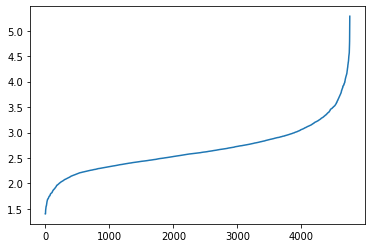

In [ ]:
## CODE USED TO FINED EPS VALUE == NO NEED TO RUN THIS AGAIN
if True: 
    from kneed import KneeLocator
    from sklearn.neighbors import NearestNeighbors

    # Compute the k-distances for each point
    k = 10
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(embeddings)
    distances, indices = neigh.kneighbors(embeddings)

    # Sort the distances and flatten them into a 1D array
    sorted_distances = np.sort(distances[:,k-1], axis=None)

    # Plot the k-distance graph
    import matplotlib.pyplot as plt
    plt.plot(sorted_distances)

    # Find the elbow point
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, S=1.0, curve='concave', direction='increasing')
    eps = sorted_distances[kneedle.elbow]

    print(f"Estimated eps value: {eps}")

    first_run=False

Finally, associate the cluster labels with the corresponding keys in the embedded_dict:


In [ ]:
clusters = {}
for i, key in enumerate(embedded_dict.keys()):
    cluster = labels[i]
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(key)

In [ ]:
for key, val in clusters.items():
    print(f'Cluster {key} includes {len(val)} words')

Cluster -1 includes 4322 words
Cluster 0 includes 162 words
Cluster 1 includes 6 words
Cluster 4 includes 3 words
Cluster 2 includes 4 words
Cluster 3 includes 4 words
Cluster 5 includes 7 words
Cluster 9 includes 3 words
Cluster 6 includes 5 words
Cluster 17 includes 3 words
Cluster 7 includes 6 words
Cluster 8 includes 5 words
Cluster 42 includes 3 words
Cluster 12 includes 3 words
Cluster 35 includes 3 words
Cluster 10 includes 3 words
Cluster 11 includes 95 words
Cluster 36 includes 4 words
Cluster 13 includes 3 words
Cluster 18 includes 4 words
Cluster 22 includes 3 words
Cluster 14 includes 3 words
Cluster 39 includes 3 words
Cluster 26 includes 3 words
Cluster 15 includes 3 words
Cluster 16 includes 3 words
Cluster 33 includes 3 words
Cluster 19 includes 15 words
Cluster 20 includes 3 words
Cluster 21 includes 5 words
Cluster 23 includes 3 words
Cluster 41 includes 4 words
Cluster 30 includes 3 words
Cluster 34 includes 3 words
Cluster 43 includes 3 words
Cluster 24 includes 3 w

**What does it means if the key is -1 ?**

In [ ]:
clusters[6]

['two', 'three', 'four', 'five', 'six']

In [ ]:
clusters[3]

['disappointed', 'surprised', 'possibly', 'upset']

In [ ]:
clusters[0][:10]

['this', 'it', 'good', 'not', 'you', 'well', 'but', 'that', 'have', 'really']

In [ ]:
clusters[-1][:10]

['the', 'and', 'a', 'of', 'great', 'is', 'very', 'to', 'i', 'for']

 PCA - ploting the clusters using

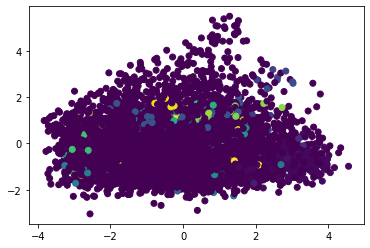

In [ ]:
# Import the necessary libraries
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract the embeddings from the embedded_dict and store them in a numpy array
embeddings = np.array(list(embedded_dict.values()))

# Perform PCA on the embeddings to reduce their dimensionality to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Get the cluster labels assigned by DBSCAN
labels = dbscan.labels_

# Plot the 2D embeddings with different colors for each cluster
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.show()

T-SNE - plotting the clusters

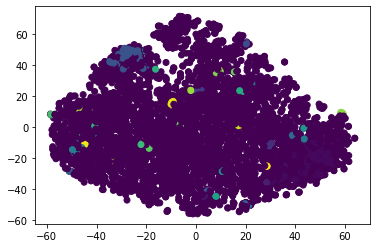

In [ ]:
# Import the necessary libraries
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the embeddings from the embedded_dict and store them in a numpy array
embeddings = np.array(list(embedded_dict.values()))

# Perform t-SNE on the embeddings to reduce their dimensionality to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Get the cluster labels assigned by DBSCAN
labels = dbscan.labels_

# Plot the 2D embeddings with different colors for each cluster
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.show()

## 5) Change all words in the Dict to "Centroid" or choose a new words of our own.
replace it in the original text of the dataframe.


In [ ]:
#TBD

## 6) Check if we get k=2

### 6.1) Create BoW representation

Lemmatizing

In [ ]:
# Credit: https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial 

import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Defining the document
    doc = nlp(doc) 

    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    #if len(txt) > 2:
    #    return ' '.join(txt)
    return ' '.join(txt)

In [ ]:
import re

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df_short_sentences['txt'])

In [ ]:
train_sentences_lemmas = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

Removing documents with None

In [ ]:
train_sentences_lemmas = [d for d in train_sentences_lemmas if d ]

Before and after cleaning:

In [ ]:
print('Before:\t', df_short_sentences['txt'][6])
print('After:\t',train_sentences_lemmas[6])

Before:	 detecto 339: excellent. assembly easy, works perfectly and is made in usa.highly recommmed detecto products.
After:	 detecto excellent assembly easy work perfectly usa highly recommme detecto product


Vectorizing

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')

count_data = vectorizer.fit_transform(train_sentences_lemmas)

#create dataframe
bow_dataframe = pd.DataFrame(count_data.toarray(),columns=vectorizer.get_feature_names_out())
bow_dataframe

,aaaaaaaaaaaaaaahhhhhhhhhhhhhhhwe,aaaaaaaaaaggggggggggggggghhhhhhhhhh,aaaaaeesssssssooooooooommmmeeee,aaaaarrrrrrrgggggghhhhh,abdullah,abercrombie,ability,abound,absolute,absolutely,...,zu,zum,zurich,zzzzzzzzzzzzz,zzzzzzzzzzzzzz,zzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Find sentences with low anonymity

In [ ]:
uniq_arr, uniq_cnt = np.unique(count_data.toarray(), axis=0, return_counts=True)

In [ ]:
print('The current k value is', min(uniq_cnt))

The current k value is 1


In [ ]:
# Testing
arr = [[4, 4, 5], [4, 4, 5], [7, 7, 7]]
np.unique(arr, axis=0, return_counts=True)

(array([[4, 4, 5],
        [7, 7, 7]]), array([2, 1]))

### 6.2) Collecting the above code into one anonimity test function

In [ ]:
def lemmatize_docs(docs):
    """ Lemmatizes documents using spacy """
    brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in docs)
    clean_docs = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
    clean_docs = [d for d in clean_docs if d]
    return clean_docs

In [ ]:
# CountVectorizer is defined only once
vectorizer = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')

def get_pesonal_docs(docs, min_k = None):
    """ If K not given, returns the minimal current k and the corresponding documents.
        If k is given, return the documents with k or less neighbohrs  """
    
    # Lemmatizing the documents
    ldocs = lemmatize_docs(docs)

    # Vectorizing
    count_data = vectorizer.fit_transform(ldocs)
    
    # Counting unique values
    uniq_arr, uniq_cnt = np.unique(count_data.toarray(), axis=0, return_counts=True)
    if not min_k:
        min_k = min(uniq_cnt)
    
    # All the unique vectors
    un_anon = uniq_arr[uniq_cnt <= min_k]

    # Getting the unique vectore indeces
    indeces_arr = None
    for row in un_anon:
        similar_vals = np.where((count_data.toarray() == (row)).all(axis=1))
        similar_vals_arr = np.expand_dims(similar_vals[0], axis=0)
        if indeces_arr is None:  # First iteration
            indeces_arr = similar_vals_arr
        else:
            indeces_arr = np.concatenate((indeces_arr, similar_vals_arr), axis=0)
    
    # Getting the unique indeces
    indeces_arr = np.unique(indeces_arr, axis=0).astype(int)
    #print(np.where(count_data.toarray() == un_anon[range(un_anon.shape[0]),:]))
    return min_k, un_anon, indeces_arr


In [ ]:
corpus = ['I love banana', 'banana I love', 'orange big', 'big orange', 'big orange']
min_k, un_anon, indeces_arr = get_pesonal_docs(corpus)
print(indeces_arr)
for row in indeces_arr:
    docs = []
    for i in row:
        docs.append(corpus[i])
    print(docs)

        
#print([corpus[i] for i in indeces_arr])

[[0 1]]
['I love banana', 'banana I love']


## 7) Finding neighboring words

Defining a function to find the neihboring words from the same cluster

In [ ]:
def get_neighbors_words(cluster_dic, word):
    """ Gets the other words in the cluster"""
    ret_list = []
    for key, vals in cluster_dic.items():
        if word in vals:
            ret_list += vals
    return ret_list

Defininig a function that gets a words, find the neighboring words and returns the general word using word embedding

In [ ]:
def get_general_word(cluster_dic, we_model, word):
    """ Find the nearest words by clusters and 
    returns the most similar words usind word embedding"""
    neighbors_words = get_neighbors_words(cluster_dic, word)
    if neighbors_words:
        we_word = we_model.most_similar(neighbors_words, topn=1)[0][0]
    else:
        we_word = None
    return we_word

Testing

In [ ]:
get_general_word(clusters, glove_model, 'four')

'few'

In [ ]:
get_general_word(clusters, glove_model, 'red')

'green'

In [ ]:
get_general_word(clusters, glove_model, 'hello')

'example'

### 8) Changing unique words

Defining the protected words

In [ ]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

sw = stopwords.words('english')

protected_words = sw + []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In order to ignore protected words in the unique documents count, we will create an alternative document list, in which we will remove the proected words from the word list

In [ ]:
def remove_from_docs(docs, prot_word_list):
    """ Removes words from documen """
    new_docs = []
    for d in docs:
        one_doc = ''
        for w in d.split(' '):
            if w not in prot_word_list:
                one_doc = f'{one_doc} {w}'
        new_docs.append(one_doc)
    return new_docs

#train_sentences_lemmas
remove_from_docs(['is not great', 'hi hi is', 'orange'], protected_words)

[' great', ' hi hi', ' orange']

In [ ]:
df_short_no_prot = remove_from_docs(df_short_sentences['txt'], protected_words)
min_k, un_anon, indeces_arr = get_pesonal_docs(df_short_no_prot)

In [ ]:
min_k

1

In [ ]:
un_anon

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
indeces_arr

array([[   0],
       [   1],
       [   2],
       ...,
       [1516],
       [1517],
       [1518]])

In [ ]:
for row in indeces_arr:
    docs = []
    for i in row:
        docs.append(df_short_no_prot[i])
    print(docs)

[" frida's attractive soundtrack sister: utterly amazing unique sound. voice powerful."]
[" disappointing. deserve 'classic': length:: 3:49 minsfahrenheit 451fahrenheit 451: novel"]
[" question thought: would nietzsche criticize ramana maharshi's philosophicaland ethical system thought?"]
[' first knight (cassette): excellent service, prompt delivery, excellent conditonas described, packaged well.would use again.']
[' great purchase: installed seconds. great performance. excellent eliminate phone line dependency.']
[' bad computer...nice screen: bad computer................blue screen mania."breathes heavy"...........overall.bad computer....dont self.']
[' detecto 339: excellent. assembly easy, works perfectly made usa.highly recommmed detecto products.']
[' great masterpiece: deliciously skewers liberalism. smug liberal understand enjoy fun.']
[' great documentary: documentary rocks. great budding entrepreneurs, entertaining anybody.']
[' utter rubbish: waste money. boring needlessly 